<a href="https://colab.research.google.com/github/rajbhoyar729/tooth-health/blob/main/Copy_of_notebookbe064cc985.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tooth-discoloration:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4744697%2F8046441%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240406%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240406T155015Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6481019dc6e6209a3c373b48765bdcd6f005945d989f1ab4a9ae4ba0e6c6cae5b095744b7a0199f51094e41db4b8074b732830f43ff3f25496be66ea3b8fcf8b00263c37ee942aeb7f35fe8f218897fa7959fffa8e4fb6db3d0afe3f38e949856b49ac2feec9216932d3fc8f9183280a19d4837814106305a0475a70591c1ce618c430c858bc4f3645dd9b78fd858beee436404fdd6206781104d2265c69e0b526e26a9a027f558dde0aaf60abb9cb7089396e0c67819b016fa39c361bb2f11ab11c70bc88cd106d080bec12bb0578d087364f8e0cde5ca825fab20f17e2bae5b844b97ba5422b6ae6b2b14b3fd3336b072edc9521368b4cdb17398f98cc5cac'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 28285148 bytes downloaded
Downloaded and uncompressed: tooth-discoloration
Data source import complete.


# Introduction

- In the field of dentistry, the early detection and diagnosis of dental caries (commonly known as cavities) play a crucial role in preserving oral health and preventing more severe dental issues. With the advancements in machine learning and computer vision, it is now possible to leverage these technologies to develop automated systems that aid in the identification and classification of caries in oral images.

- In this project, we aim to build a machine learning model for the detection of caries in oral images. We will employ techniques such as data augmentation and regularization to enhance the model's generalization. By utilizing a dataset containing labeled images of oral scans, we will train and evaluate the model's performance in accurately classifying images as either showing signs of caries or being caries-free.

In [2]:
# Import necessary libraries
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [3]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [4]:
# Set paths
train_dir = '/kaggle/input/tooth-discoloration/Tooth Discoloration/trainingdata'
test_dir = '/kaggle/input/tooth-discoloration/Tooth Discoloration/testingdata'

# Exploratory Data Analysis (EDA)

In [5]:
# Count the number of images in each class
train_caries_count = len(os.listdir(os.path.join(train_dir, 'Discoloration')))
train_no_caries_count = len(os.listdir(os.path.join(train_dir, 'Non_Discoloration')))
test_caries_count = len(os.listdir(os.path.join(test_dir, 'Discoloration')))
test_no_caries_count = len(os.listdir(os.path.join(test_dir, 'Non_Discoloration')))

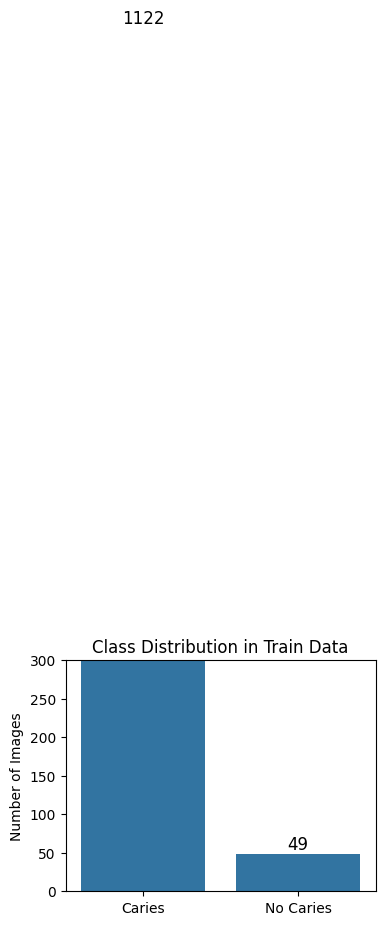

In [6]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[train_caries_count, train_no_caries_count])
plt.title('Class Distribution in Train Data')
plt.ylabel('Number of Images')
plt.ylim(0, 300)

# Add data labels to the bars
for i, count in enumerate([train_caries_count, train_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

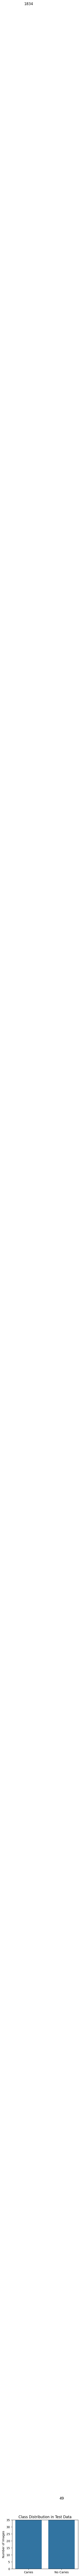

In [7]:
# Create a bar plot to visualize class distribution
plt.figure(figsize=(4, 3))
sns.barplot(x=['Caries', 'No Caries'], y=[test_caries_count, test_no_caries_count])
plt.title('Class Distribution in Test Data')
plt.ylabel('Number of Images')
plt.ylim(0, 35)

# Add data labels to the bars
for i, count in enumerate([test_caries_count, test_no_caries_count]):
    plt.text(i, count, str(count), ha='center', va='bottom', fontsize=12)

plt.show()

### Histograms of Pixel Intensities

(array([127152.,  45683.,  49620.,  50959.,  53466.,  56326.,  64481.,
         59160.,  63219.,  70584.,  95964.,  89256., 104467., 107045.,
        111393., 116898., 120844., 133450., 140381., 145690., 170750.,
        151831., 164477., 171264., 176579., 182144., 184808., 185809.,
        191180., 194955., 234560., 201794., 202778., 207100., 212421.,
        209338., 206199., 209069., 206170., 196868., 235877., 182172.,
        168269., 156780., 146822., 150158., 144830., 125430., 115969.,
        283433.]),
 array([  0.        ,   5.0999999 ,  10.19999981,  15.30000019,
         20.39999962,  25.5       ,  30.60000038,  35.70000076,
         40.79999924,  45.90000153,  51.        ,  56.09999847,
         61.20000076,  66.30000305,  71.40000153,  76.5       ,
         81.59999847,  86.69999695,  91.80000305,  96.90000153,
        102.        , 107.09999847, 112.19999695, 117.30000305,
        122.40000153, 127.5       , 132.6000061 , 137.69999695,
        142.80000305, 147.8999939 , 

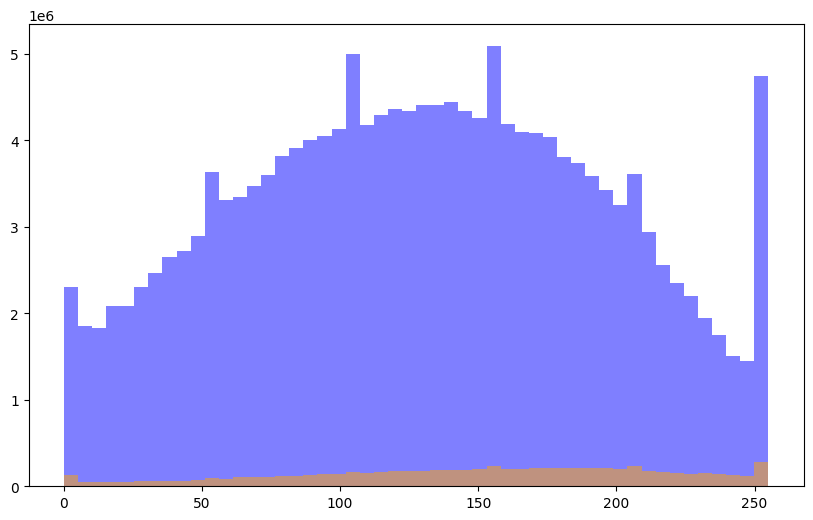

In [8]:
# Define the target image size
target_size = (224, 224)

# Load caries images as a NumPy array
caries_image_paths = [os.path.join(train_dir, 'Discoloration', filename) for filename in os.listdir(os.path.join(train_dir, 'Discoloration'))]
caries_images = []
for img_path in caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    caries_images.append(img_array)
caries_images = np.array(caries_images)

# Load no caries images as a NumPy array
no_caries_image_paths = [os.path.join(train_dir, 'Non_Discoloration', filename) for filename in os.listdir(os.path.join(train_dir, 'Non_Discoloration'))]
no_caries_images = []
for img_path in no_caries_image_paths:
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    no_caries_images.append(img_array)
no_caries_images = np.array(no_caries_images)

# Plot histograms of pixel intensities
plt.figure(figsize=(10, 6))
plt.hist(caries_images.flatten(), bins=50, color='blue', alpha=0.5, label='Caries')
plt.hist(no_caries_images.flatten(), bins=50, color='orange', alpha=0.5, label='No Caries')

## Displaying Sample Images from Each Class

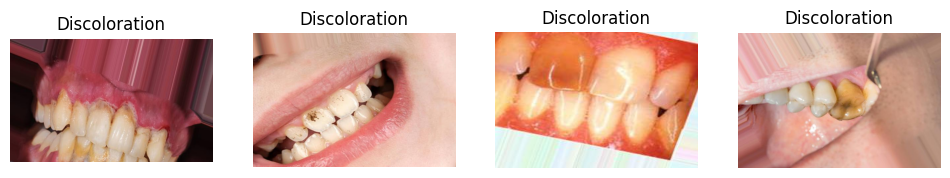

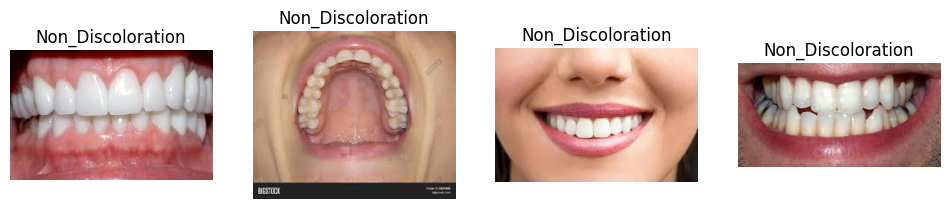

In [9]:
def display_samples(class_name, directory):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        img = Image.open(image_path)
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_samples('Discoloration', train_dir)
display_samples('Non_Discoloration', train_dir)

# Data Augmentation

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224,),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224,),
    batch_size=32,
    class_mode='binary'
)

Found 1171 images belonging to 2 classes.
Found 1883 images belonging to 2 classes.


## Displaying Some Augmented Images

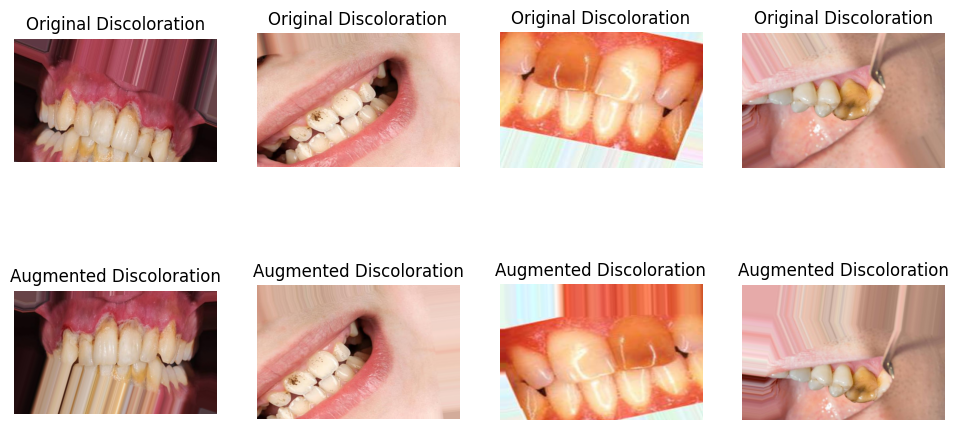

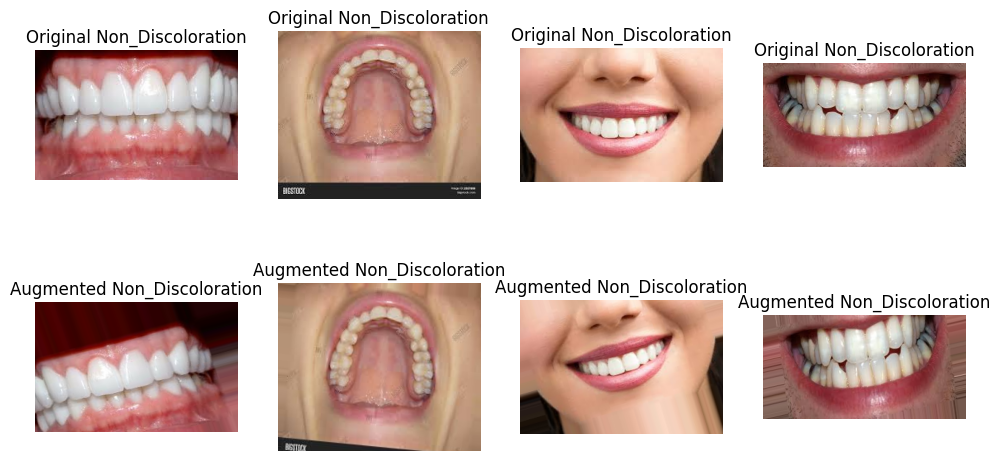

In [11]:
def display_augmented_images(class_name, directory, generator):
    plt.figure(figsize=(12, 6))
    for i in range(4):
        original_image_path = os.path.join(directory, class_name, os.listdir(os.path.join(directory, class_name))[i])
        original_img = Image.open(original_image_path)

        # Convert PIL Image to NumPy array
        original_array = np.array(original_img)

        # Apply random transformation to the NumPy array
        augmented_array = generator.random_transform(original_array)

        augmented_img = Image.fromarray(augmented_array)

        plt.subplot(2, 4, i + 1)
        plt.imshow(original_img)
        plt.title(f'Original {class_name}')
        plt.axis('off')

        plt.subplot(2, 4, i + 5)
        plt.imshow(augmented_img)
        plt.title(f'Augmented {class_name}')
        plt.axis('off')

    plt.show()

# Display augmented images for 'caries' class
display_augmented_images('Discoloration', train_dir, train_datagen)

# Display augmented images for 'no_caries' class
display_augmented_images('Non_Discoloration', train_dir, train_datagen)

## Modeling

In [12]:
'''import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

# Load MobileNetV3Small as base model (adjust input shape if needed)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of MobileNetV3Small (optional, adjust as needed)
for layer in base_model.layers:
    layer.trainable = False  # You can fine-tune specific layers later

# Create a Sequential model
model = Sequential()

# Add the MobileNetV3Small base model
model.add(base_model)

# Add custom layers on top of MobileNetV3Small (adjust units and activation as needed)
model.add(Flatten())
model.add(Dense(256, activation='relu'))  # Consider experimenting with different neuron numbers
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Adjust activation based on your task (binary classification)

# Compile the model (consider adjusting optimizer and loss function)
model.compile(optimizer=Adam(learning_rate=0.0001),  # Experiment with different learning rates
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()'''

"import tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, Dropout, Flatten\nfrom tensorflow.keras.applications import MobileNetV2\nfrom tensorflow.keras.optimizers import Adam\n\n# Load MobileNetV3Small as base model (adjust input shape if needed)\nbase_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))\n\n# Freeze the layers of MobileNetV3Small (optional, adjust as needed)\nfor layer in base_model.layers:\n    layer.trainable = False  # You can fine-tune specific layers later\n\n# Create a Sequential model\nmodel = Sequential()\n\n# Add the MobileNetV3Small base model\nmodel.add(base_model)\n\n# Add custom layers on top of MobileNetV3Small (adjust units and activation as needed)\nmodel.add(Flatten())\nmodel.add(Dense(256, activation='relu'))  # Consider experimenting with different neuron numbers\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation='sigmoid'))  # Adjust activation based on

In [13]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 394272)            0         
                                                                 
 dense (Dense)               (None, 128)               50466944  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [ ]:

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

Epoch 1/50
37/37 [==============================] - 138s 4s/step - loss: 3.1890 - accuracy: 0.9394 - val_loss: 1.0673 - val_accuracy: 0.9740
Epoch 2/50
37/37 [==============================] - 146s 4s/step - loss: 0.6596 - accuracy: 0.9582 - val_loss: 0.3246 - val_accuracy: 0.9740
Epoch 3/50
37/37 [==============================] - 123s 3s/step - loss: 0.3156 - accuracy: 0.9582 - val_loss: 0.2065 - val_accuracy: 0.9740
Epoch 4/50
37/37 [==============================] - 123s 3s/step - loss: 0.2804 - accuracy: 0.9582 - val_loss: 0.1956 - val_accuracy: 0.9740
Epoch 5/50
37/37 [==============================] - 134s 4s/step - loss: 0.2682 - accuracy: 0.9582 - val_loss: 0.2720 - val_accuracy: 0.9740
Epoch 6/50
37/37 [==============================] - 147s 4s/step - loss: 0.2813 - accuracy: 0.9573 - val_loss: 0.1886 - val_accuracy: 0.9740
Epoch 7/50
37/37 [==============================] - 134s 4s/step - loss: 0.2450 - accuracy: 0.9582 - val_loss: 0.2018 - val_accuracy: 0.9740
Epoch 8/50
37

In [ ]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc:.2f}")

In [ ]:
# Generate predictions
predictions = model.predict(test_generator)
y_pred = np.round(predictions)

In [ ]:
# Suppress UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Confusion matrix and classification report
conf_matrix = confusion_matrix(test_generator.classes, y_pred)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(test_generator.classes, y_pred, target_names=class_names))

# Remove the filter after using
warnings.filterwarnings("default", category=UndefinedMetricWarning)

In [ ]:
# Plot learning curves
plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_generator.classes, predictions)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

## Predicting Some Images

In [ ]:
# Load a few test images and predict their labels
num_images_to_predict = 16  # Change this to the number of images you want to predict

# Get a few test images and their true labels
test_images, true_labels = next(test_generator)

# Predict labels for the test images
predicted_labels = model.predict(test_images)

# Convert predicted labels to binary (0 or 1)
predicted_labels = np.round(predicted_labels)

# Define class names
class_names = ['d', 'n_d']

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = (num_images_to_predict + num_rows - 1) // num_rows

# Display the test images along with their predicted labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_predict):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(test_images[i])
    plt.title(f"True: {class_names[int(true_labels[i])]}, Predicted: {class_names[int(predicted_labels[i])]}")
    plt.axis('off')

plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust the spacing between subplots
plt.show()

In [ ]:
model.save('tensor.h5')

In [ ]:
import tensorflow as tf

# Load the pre-trained model
model_path = '/content/tensor.h5'  # Change to your model's path
model = tf.keras.models.load_model(model_path)

# Define the new model architecture with BatchNormalization layer
new_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=model.input_shape[1:]),  # Skip the first input layer
    tf.keras.layers.BatchNormalization(axis=-1),  # Add BatchNormalization layer
    model  # Add the pre-trained model
])

# Save the modified model
new_model.save('ten.h5')


In [ ]:
import tensorflow as tf
import numpy as np
import cv2

# Load the model
model_path = '/content/ten.h5'  # Change to your model's path
model = tf.keras.models.load_model(model_path)

# Preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Assuming input size is 224x224
    img = img.astype("float") / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Test an image
image_path = '/content/Tooth_Discoloration_0_557.jpeg'  # Change to your image's path
image = preprocess_image(image_path)
predictions = model.predict(image)
model.add(tf.keras.layers.BatchNormalization(axis=-1))


# Print the predictions
print(predictions)
